In [1]:
import h5py
import sys
import time
sys.path.append("/users/munozr/mycodes")
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import LinData
from matplotlib.collections import LineCollection
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools.lineint import lineint

In [2]:
param32 = RRead.read_parameters('pflrw_d3e2_L1206_t1_N32_EdS_GRH_spin_CPunc_MR')
Lin32 = LinData.LinData_Class(param32)
all_h5it32 = RRead.collect_h5iteration(Lin32.param)
all_h5it32 = all_h5it32[0::2]
L = param32['Lx']

 read time file


In [3]:
def make_big_array(data):
    N = [np.shape(d)[0] for d in data]
    xbig = np.arange(-L/2, L/2, param32['dx']/(2**(len(data)-1))) / L
    Nbig = len(xbig)
    big_data = np.zeros((Nbig, Nbig, Nbig))

    for rl in range(len(data)):
        dxg = param32['dx']/(2**rl)
        Lg = N[rl]*dxg
        xmin = (-Lg/2 + (dxg/2)*(N[rl]%2))/L
        imin = np.argmin(abs(xbig - xmin))
        nrepeat = 2**(3-rl)
        imax = imin + N[rl]*nrepeat
        big_data[imin:imax, imin: imax, imin:imax] = np.repeat(np.repeat(np.repeat(
            data[rl], nrepeat, axis=0), nrepeat, axis=1), nrepeat, axis=2)
    return xbig, big_data

def cut(rl, data):
    if rl > 1:
        icut = 3
        return RRead.fixij(data[icut:-icut, icut:-icut, icut:-icut])
    else:
        return RRead.fixij(data)

In [4]:
mpl.rcParams['font.size'] = 30
mpl.rcParams['image.cmap'] = 'twilight_shifted'


filename = '/users/munozr/simulations/' + param32['simname'] + '/proper_distance_weight.hdf5'
fw = h5py.File(filename, 'r') 

allit = np.append(np.arange(34000, 73600, 200), 
                  np.arange(73800, 120000, 200))
allit = np.arange(93600, 120000, 200)

for it in RRead.progressbar(allit):
    qup1 = []
    qup2 = []
    gdet_all = []
    for rl in range(4):
        f = h5py.File(param32['h5datapath']+param32['simname']+'_it_{:06d}.hdf5'.format(it),'r')
        alpha = cut(rl, np.array(f['ADMBASE::alp it={} tl=0 rl={}'.format(it, rl)]))
        betax = cut(rl, np.array(f['ADMBASE::betax it={} tl=0 rl={}'.format(it, rl)]))
        betay = cut(rl, np.array(f['ADMBASE::betay it={} tl=0 rl={}'.format(it, rl)]))
        betaz = cut(rl, np.array(f['ADMBASE::betaz it={} tl=0 rl={}'.format(it, rl)]))
        gxx = cut(rl, np.array(f['ADMBASE::gxx it={} tl=0 rl={}'.format(it, rl)]))
        gxy = cut(rl, np.array(f['ADMBASE::gxy it={} tl=0 rl={}'.format(it, rl)]))
        gxz = cut(rl, np.array(f['ADMBASE::gxz it={} tl=0 rl={}'.format(it, rl)]))
        gyy = cut(rl, np.array(f['ADMBASE::gyy it={} tl=0 rl={}'.format(it, rl)]))
        gyz = cut(rl, np.array(f['ADMBASE::gyz it={} tl=0 rl={}'.format(it, rl)]))
        gzz = cut(rl, np.array(f['ADMBASE::gzz it={} tl=0 rl={}'.format(it, rl)]))
        Ttt = cut(rl, np.array(f['TMUNUBASE::eTtt it={} tl=0 rl={}'.format(it, rl)]))
        Ttx = cut(rl, np.array(f['TMUNUBASE::eTtx it={} tl=0 rl={}'.format(it, rl)]))
        Tty = cut(rl, np.array(f['TMUNUBASE::eTty it={} tl=0 rl={}'.format(it, rl)]))
        Ttz = cut(rl, np.array(f['TMUNUBASE::eTtz it={} tl=0 rl={}'.format(it, rl)]))
        Txx = cut(rl, np.array(f['TMUNUBASE::eTxx it={} tl=0 rl={}'.format(it, rl)]))
        Txy = cut(rl, np.array(f['TMUNUBASE::eTxy it={} tl=0 rl={}'.format(it, rl)]))
        Txz = cut(rl, np.array(f['TMUNUBASE::eTxz it={} tl=0 rl={}'.format(it, rl)]))
        Tyy = cut(rl, np.array(f['TMUNUBASE::eTyy it={} tl=0 rl={}'.format(it, rl)]))
        Tyz = cut(rl, np.array(f['TMUNUBASE::eTyz it={} tl=0 rl={}'.format(it, rl)]))
        Tzz = cut(rl, np.array(f['TMUNUBASE::eTzz it={} tl=0 rl={}'.format(it, rl)]))
        tauOD = np.array(f['COSMOLAPSE::tau it={} tl=0 rl=0'.format(it)])[16,16,16]
        f.close()
        
        N = np.shape(alpha)[0]

        Box0 = np.zeros((N, N, N))
        Box1 = np.ones((N, N, N))

        betaup = np.array([betax, betay, betaz])
        nup = np.array([Box1, -betax, -betay, -betaz])/alpha
        del alpha, betax, betay, betaz, Box1
        gdown = np.array([[gxx, gxy, gxz],
                          [gxy, gyy, gyz],
                          [gxz, gyz, gzz]])
        Tdown = np.array([[Ttt, Ttx, Tty, Ttz],
                         [Ttx, Txx, Txy, Txz],
                         [Tty, Txy, Tyy, Tyz],
                         [Ttz, Txz, Tyz, Tzz]])
        del Ttt, Ttx, Tty, Ttz, Txx, Txy, Txz, Tyy, Tyz, Tzz

        betadown = np.einsum('i...,ij...->j...', betaup, gdown)
        bsqr = np.einsum('i...,i...->...', betaup, betadown)
        gdown4 = np.array([[bsqr, betadown[0], betadown[1], betadown[2]],
                          [betadown[0], gxx, gxy, gxz],
                          [betadown[1], gxy, gyy, gyz],
                          [betadown[2], gxz, gyz, gzz]])
        del betaup, betadown, bsqr, gxx, gxy, gxz, gyy, gyz, gzz

        gup = RRead.inv3(gdown)
        gdet = RRead.det3(gdown)
        gup4 = np.array([[Box0, Box0, Box0, Box0],
                        [Box0, gup[0,0], gup[0,1], gup[0,2]],
                        [Box0, gup[1,0], gup[1,1], gup[1,2]],
                        [Box0, gup[2,0], gup[2,1], gup[2,2]]])
        del gdown, gup, Box0

        # energy flux
        qup = - np.einsum('bi...,ba...,a...->i...', gup4, Tdown, nup)
        del Tdown, nup

        # Now I only want Jz on the z=0 plane
        qup1 += [qup[1]]
        qup2 += [qup[2]]
        gdet_all += [gdet]
        del qup
    xbig, big_qup1 = make_big_array(qup1)
    xbig, big_qup2 = make_big_array(qup2)
    big_qup = np.array([big_qup1, big_qup2])
    del big_qup1, big_qup2, qup1, qup2
    xbig, big_gdet = make_big_array(gdet_all)
    del gdet_all
    
    # code coord
    N = len(xbig)
    d3xc, d3yc, d3zc = np.meshgrid(xbig, xbig, xbig, indexing='ij')
    xic = np.array([d3xc, d3yc])
    
    # proper coord
    d3xp = np.zeros(np.shape(d3xc))
    d3yp = np.zeros(np.shape(d3yc))
    
    iz = int(N/2)
    for ix in range(N):
        for iy in range(N):
            idx = '({},{},{})'.format(ix,iy,iz)
            segments = np.array(fw[idx+' segments'])
            indices = np.array(fw[idx+' indices'])
            pradius = np.sum([big_gdet[tuple(indices[i])]*segments[i]
                              for i in range(len(segments))])

            cradius = np.sqrt(d3xc[ix,iy,iz]**2 + d3yc[ix,iy,iz]**2)
            phi = np.arccos(RRead.safe_division(d3xc[ix,iy,iz], cradius))
            if d3yc[ix,iy,iz]<0:
                phi = 2*np.pi - phi
            if d3xc[ix,iy,iz]==0 and d3yc[ix,iy,iz]==0:
                phi = 0

            d3xp[ix,iy,iz] = pradius * np.cos(phi)
            d3yp[ix,iy,iz] = pradius * np.sin(phi)
    xip = np.array([d3xp, d3yp])
    
    # Levi Civita
    LC = np.zeros((2, 2, N, N, N))
    i1 = 2 # I've set the first indice to z
    for i2 in [0,1]:
        for i3 in np.delete([0,1], i2):
            num = (i2-i1) * (i3-i1) * (i3-i2)
            den = (abs(i2-i1) * abs(i3-i1) * abs(i3-i2))
            LC[i2,i3,:,:,:] = float(num / den)
            
    # angular momentum density
    Jz = np.einsum('jk...,j...,k...->...', LC, xip, big_qup)
    big_data = Jz
    
    vmax = np.max(big_data)
    vmin = - vmax
    
    icent = int(len(xbig)/2)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xbig, xbig, big_data[:,:,icent], shading='gouraud', vmin = vmin, vmax = vmax)
    plt.colorbar(format='%.0e', extend='both')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/L$')
    plt.title(r'$\mathcal{J}_z$,$\;$ it = '+r'{},$\;$ '.format(it)
              + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin32.an_initial(tauOD)))
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.savefig('/users/munozr/simulations/' + param32['simname'] + '/Jz_it={:06d}'.format(it))
    plt.close(plt.gcf())
fw.close()

[██████████████████████████████] 100.00% Est wait 00d 00h 00m 0.0s

total time used: 00d 02h 09m 28.3s




# Using grid coordinates

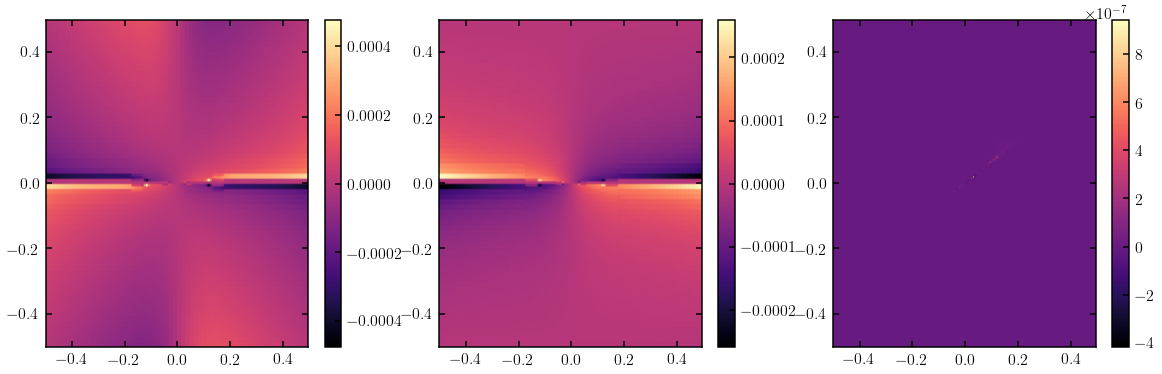

In [6]:
it = 100000
# J_x

icent = int(len(xbig)/2)
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.pcolormesh(xbig, xbig, big_data[icent,:,:], shading='gouraud')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(xbig, xbig, big_data[:,icent,:], shading='gouraud')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(xbig, xbig, big_data[:,:,icent], shading='gouraud')
plt.colorbar()

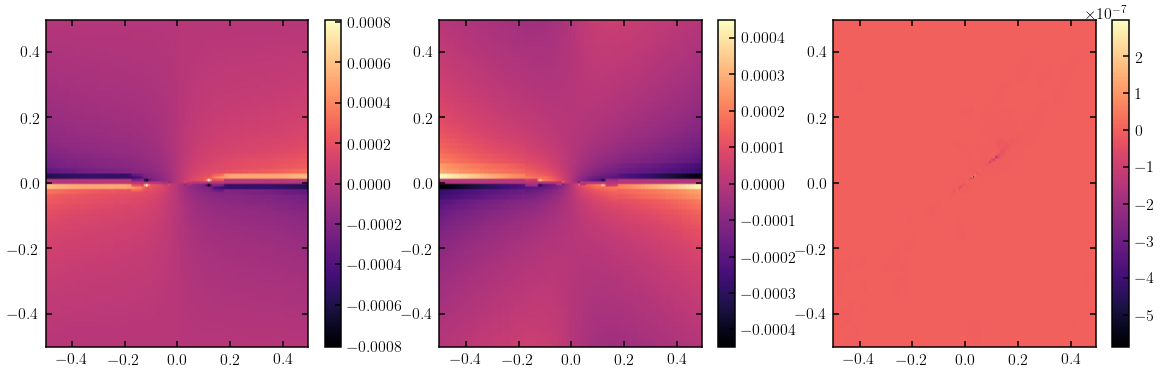

In [8]:
# J_y

icent = int(len(xbig)/2)
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.pcolormesh(xbig, xbig, big_data[icent,:,:], shading='gouraud')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(xbig, xbig, big_data[:,icent,:], shading='gouraud')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(xbig, xbig, big_data[:,:,icent], shading='gouraud')
plt.colorbar()

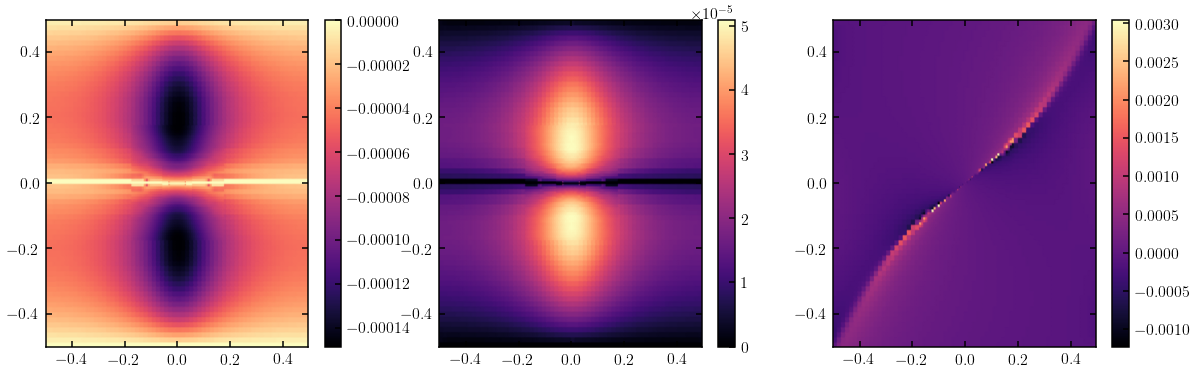

In [10]:
# J_z

icent = int(len(xbig)/2)
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.pcolormesh(xbig, xbig, big_data[icent,:,:], shading='gouraud')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(xbig, xbig, big_data[:,icent,:], shading='gouraud')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(xbig, xbig, big_data[:,:,icent], shading='gouraud')
plt.colorbar()